In [3]:
!pip install librosa  # для построения волн аудиосигнала

In [3]:
import librosa

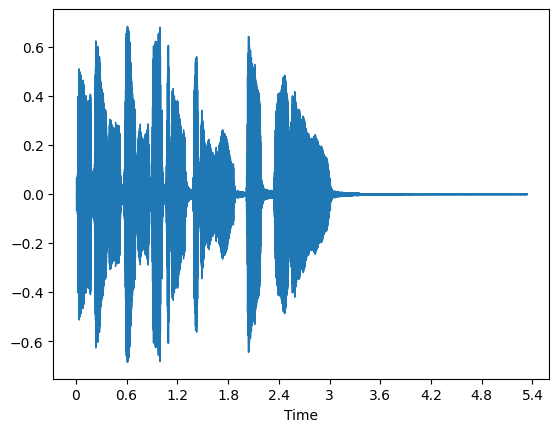

In [4]:
array, sr = librosa.load(librosa.ex('trumpet'))

librosa.display.waveshow(array, sr=sr)

In [5]:
array

array([-1.4068222e-03, -4.4607258e-04, -4.1098078e-04, ...,
        7.9623051e-06, -3.0417003e-05,  1.2765067e-05], dtype=float32)

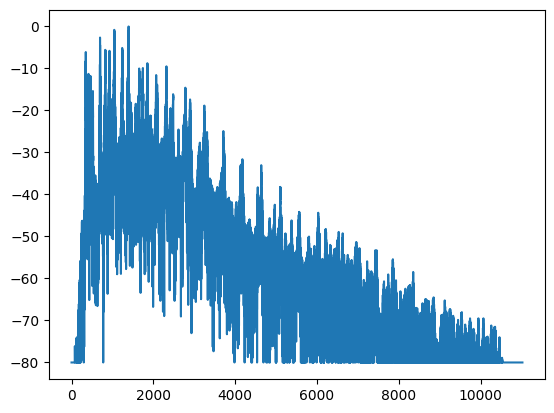

In [6]:
# визуализация сигнала с помощью частотного спектра: преобразование Фурье
import numpy as np
import matplotlib.pyplot as plt

dft_input = array

# применим окно для того чтобы не было утечки спектра 
window = np.hanning(len(dft_input))
windowed_input = window*dft_input

# БПФ
dft = np.fft.rfft(windowed_input)

# амплитуда для визуализации
ampl = np.abs(dft)
ampl_db = librosa.amplitude_to_db(ampl, ref=np.max)

#частота
fr = librosa.fft_frequencies(sr=sr,n_fft=len(dft_input))

plt.plot(fr, ampl_db)


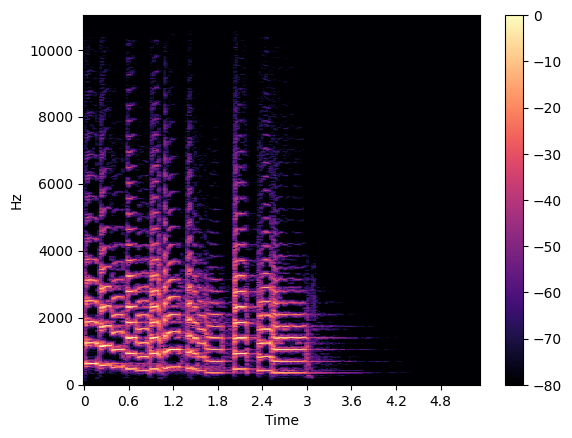

In [7]:
# спектограмма. амплитуда показывает мощность частотной составляющей

s = librosa.stft(array)
s_db = librosa.amplitude_to_db(np.abs(s), ref=np.max)

librosa.display.specshow(s_db, x_axis='time', y_axis='hz')
plt.colorbar()

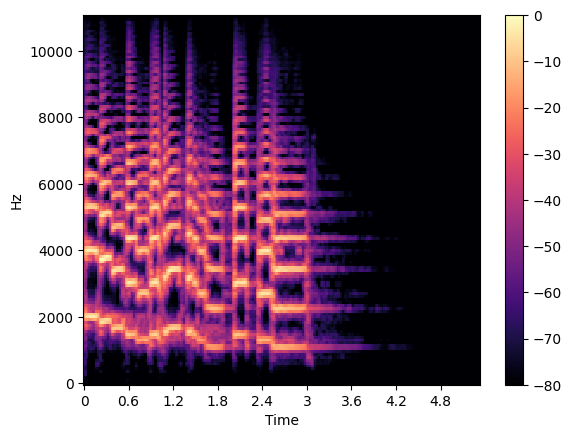

In [8]:
# мелспектограмма - аппроксимирует нелинейную частотную характеристику уха

m = librosa.feature.melspectrogram(y=array, sr=sr)
m_db = librosa.power_to_db(m, ref=np.max)

librosa.display.specshow(m_db, x_axis='time', y_axis='hz')
plt.colorbar()

In [9]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")

minds

minds14.py:   0%|          | 0.00/5.83k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.28k [00:00<?, ?B/s]

The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


MInDS-14.zip:   0%|          | 0.00/471M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [10]:
ex = minds[0]

ex

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [11]:
id2label = minds.features['intent_class'].int2str

id2label(ex['intent_class'])

'pay_bill'

In [12]:
minds = minds.remove_columns(['english_transcription', 'lang_id'])

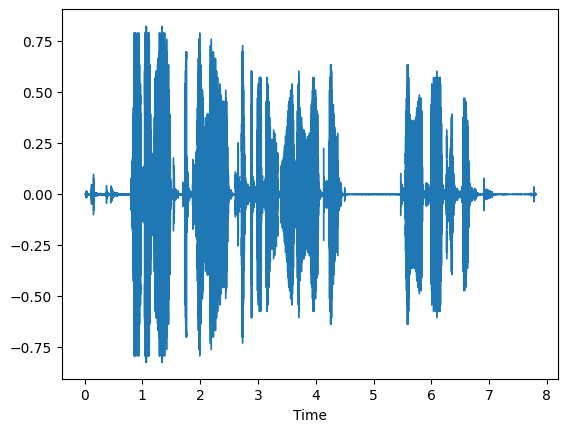

In [13]:
librosa.display.waveshow(y=ex['audio']['array'], sr=ex['audio']['sampling_rate'])

In [14]:
# передискритизация данных

from datasets import Audio

minds = minds.cast_column('audio', Audio(sampling_rate=16000))

minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/f9018fd3747971e77d59e6c5da3fdf9d5bb914c495e16c23e1fe47c921d76a7a/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

In [15]:
# фильтрация по длительности аудио

max_audio_length = 20

def is_audio_length_longer(length):
    return length<max_audio_length

duration = [librosa.get_duration(path=x) for x in minds['path']]
minds = minds.add_column('duration', duration)

minds = minds.filter(is_audio_length_longer, input_columns=['duration'])

minds = minds.remove_columns(['duration'])


minds

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

In [21]:
# препроцессинг аудиоданных - чтобы привести аудиоданные в нужный формат для подачи в модель
# (в этом случае лог мел спектограммы)

from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

def prepare_dataset(ex):
    return processor(ex['audio']['array'], sampling_rate=ex['audio']['sampling_rate'], 
                            padding=True)

minds = minds.map(prepare_dataset)

minds

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

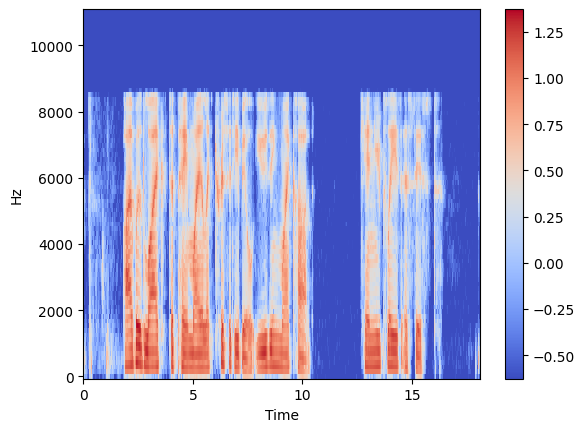

In [22]:
librosa.display.specshow(np.asarray(minds[0]['input_features'][0]), x_axis='time', y_axis='hz')
plt.colorbar()